# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from helper_functions import show_images, do_pca, scree_plot, plot_component

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
azdias.shape

(891221, 85)

In [4]:
num_rows = azdias.shape[0]
num_rows

891221

In [5]:
# display feature info
pd.options.display.max_rows = 100
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


*Most of the features are categorical or ordinal*

In [6]:
# know the number of unique categories for each feature
azdias.agg(['size', 'count', 'nunique']).transpose()

,size,count,nunique
AGER_TYP,891221,891221,5
ALTERSKATEGORIE_GROB,891221,891221,5
ANREDE_KZ,891221,891221,2
CJT_GESAMTTYP,891221,886367,6
FINANZ_MINIMALIST,891221,891221,5
FINANZ_SPARER,891221,891221,5
FINANZ_VORSORGER,891221,891221,5
FINANZ_ANLEGER,891221,891221,5
FINANZ_UNAUFFAELLIGER,891221,891221,5
FINANZ_HAUSBAUER,891221,891221,5


In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
pd.options.display.max_columns = 100
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
azdias.dtypes

AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL 

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# data naturally missing
naturalmissing = azdias.isnull().sum()
naturalmissing.head()

AGER_TYP                   0
ALTERSKATEGORIE_GROB       0
ANREDE_KZ                  0
CJT_GESAMTTYP           4854
FINANZ_MINIMALIST          0
dtype: int64

In [11]:
# just checking a sample of the data identified as missing or unknown
azdias.groupby(['AGER_TYP']).size()

AGER_TYP
-1    677503
 0      8340
 1     79802
 2     98472
 3     27104
dtype: int64

#### Identify missing or unknown data values and convert them to NaNs.

In [12]:
def ParseMissing(x):
    '''
    Parse a string of missing values. It converts from a string to a list
    Output is a list of the missing values
    '''
    x1 = x.replace('[','').replace(']','').split(',')
    if x1 == ['']: return[]
    try:
        return [int(i) for i in x1]
    except ValueError:
        return x1

In [13]:
# set the index as it will be used later for joining
feat_info.set_index('attribute', inplace=True, drop=False)

In [14]:
# create a new column that holds the missing as a list rather than a text string
feat_info['missing'] = feat_info['missing_or_unknown'].apply(ParseMissing)

# Now I'm substituting missing values with np.nan
for column in list(azdias):
    missing = feat_info[feat_info.attribute == column].iloc[0]['missing']
    if len(missing) != 0:
        azdias[column].replace(missing, np.nan, inplace=True)

feat_info.head()

,attribute,information_level,type,missing_or_unknown,missing
attribute,,,,,
AGER_TYP,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
ALTERSKATEGORIE_GROB,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
ANREDE_KZ,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
CJT_GESAMTTYP,CJT_GESAMTTYP,person,categorical,[0],[0]
FINANZ_MINIMALIST,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [15]:
# checking a sample after replacement
azdias.groupby(['AGER_TYP']).size()

AGER_TYP
1.0    79802
2.0    98472
3.0    27104
dtype: int64

Add some other info to feat_info. This data will be needed later

In [16]:
# number of levels in each feature
feat_info = azdias.agg(['nunique']).transpose().join(feat_info).rename(columns={"nunique": "num_levels"})
feat_info

,num_levels,attribute,information_level,type,missing_or_unknown,missing
AGER_TYP,3,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
ALTERSKATEGORIE_GROB,4,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
ANREDE_KZ,2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
CJT_GESAMTTYP,6,CJT_GESAMTTYP,person,categorical,[0],[0]
FINANZ_MINIMALIST,5,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]
FINANZ_SPARER,5,FINANZ_SPARER,person,ordinal,[-1],[-1]
FINANZ_VORSORGER,5,FINANZ_VORSORGER,person,ordinal,[-1],[-1]
FINANZ_ANLEGER,5,FINANZ_ANLEGER,person,ordinal,[-1],[-1]
FINANZ_UNAUFFAELLIGER,5,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1]
FINANZ_HAUSBAUER,5,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1]


In [17]:
unique_vals = []
for i in feat_info.index:
    unique_vals.append(azdias[i].unique())
feat_info['unique_vals'] = unique_vals

feat_info

,num_levels,attribute,information_level,type,missing_or_unknown,missing,unique_vals
AGER_TYP,3,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]","[nan, 2.0, 3.0, 1.0]"
ALTERSKATEGORIE_GROB,4,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]","[2.0, 1.0, 3.0, 4.0, nan]"
ANREDE_KZ,2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]","[1, 2]"
CJT_GESAMTTYP,6,CJT_GESAMTTYP,person,categorical,[0],[0],"[2.0, 5.0, 3.0, 4.0, 1.0, 6.0, nan]"
FINANZ_MINIMALIST,5,FINANZ_MINIMALIST,person,ordinal,[-1],[-1],"[3, 1, 4, 2, 5]"
FINANZ_SPARER,5,FINANZ_SPARER,person,ordinal,[-1],[-1],"[4, 5, 2, 3, 1]"
FINANZ_VORSORGER,5,FINANZ_VORSORGER,person,ordinal,[-1],[-1],"[3, 2, 1, 5, 4]"
FINANZ_ANLEGER,5,FINANZ_ANLEGER,person,ordinal,[-1],[-1],"[5, 2, 1, 4, 3]"
FINANZ_UNAUFFAELLIGER,5,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1],"[5, 4, 3, 1, 2]"
FINANZ_HAUSBAUER,5,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1],"[3, 5, 2, 4, 1]"


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
allmissing = azdias.isnull().sum()
allmissing.sort_values(ascending = False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

In [19]:
allmissing_ratio = allmissing/num_rows
allmissing_ratio.sort_values(ascending = False)

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

***A large portion of the missing values are marked as missing/unknown***

In [20]:
# select outlier columns as those that have more than 33% missing data
# this figure is somehow arbitrary. One motivation to choose this figure is that
# the next missing column is 17% missing, so it's far from the 34%. There's a gap
# (or distance) here to the other columns, so I might call it an outlier.
outlier_cols = list(allmissing_ratio[allmissing_ratio > 0.33].index)
outlier_cols

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

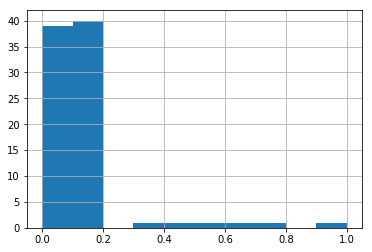

In [21]:
# Investigate patterns in the amount of missing data in each column.
allmissing_ratio.hist(bins = 10)


In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# create a new copy of the df, to keep as backup
#azdias = deepcopy(azdias_copy)
azdias_copy = deepcopy(azdias)
azdias.drop(columns = outlier_cols, inplace = True)
azdias.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

As shown in the analysis above, the columns that has the highest ratio of missing values are

| Feature          | Proportion Missing |
| ---------------- |------------------- |
| TITEL_KZ         |        0.997576   |
| AGER_TYP         |        0.769554   |
| KK_KUNDENTYP     |        0.655967   |
| KBA05_BAUMAX     |        0.534687   |
| GEBURTSJAHR      |        0.440203   |
| ALTER_HH         |        0.348137   |


It's also noticed that the next feature (descending wise) in the proportion of missing data has 17% missing data. The large gap between the above 6 features and the 7th one make this seem like a reasonable cut-off point. This conclusion is also supported by viewing the histogram above.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

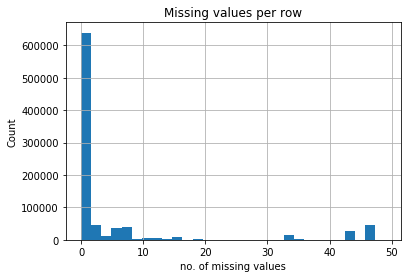

In [23]:
# How much data is missing in each row of the dataset?
azdias['missing_vals'] = azdias.isnull().sum(axis=1)

# draw a histogram of missing values per row
azdias.hist(column='missing_vals', bins = 30)
plt.xlabel('no. of missing values')
plt.ylabel('Count')
plt.title('Missing values per row');

A reasonable threshold boundary seems to be at 6

In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias['group'] = azdias['missing_vals'] > 6

azdias.groupby('group').size()

group
False    733395
True     157826
dtype: int64

**False** ==> Few missing values (less than or equal 6)  
**True** ==> Many missing values (more than 6)

In [25]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_groups(feature):
    f, axes = plt.subplots(1, 2)
    sns.countplot(x=feature, data=azdias[azdias['group'] == True], ax=axes[0])
    axes[0].set_title("Many missing")
    sns.countplot(x=feature, data=azdias[azdias['group'] == False], ax=axes[1])
    axes[1].set_title("Few missing")

[None, None, None, None, None]

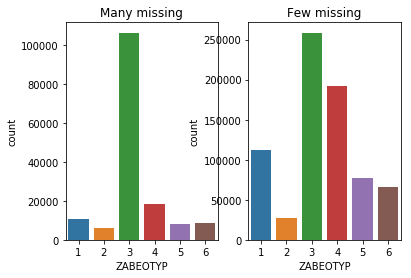

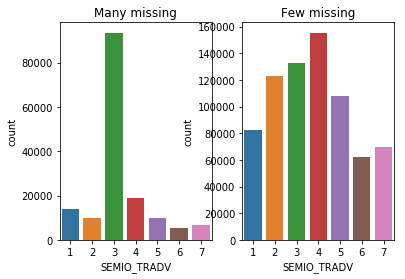

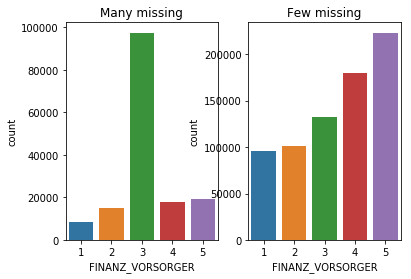

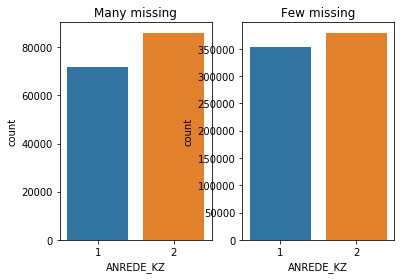

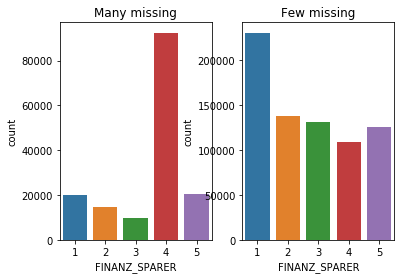

In [26]:
compare_features = ['ZABEOTYP', 'SEMIO_TRADV', 'FINANZ_VORSORGER', 'ANREDE_KZ', 'FINANZ_SPARER']
list(map(compare_groups, compare_features))

In [27]:
# drop the rows that have many missing values
print(f"Before: {azdias.shape}")
azdias.drop(azdias[azdias.group].index, inplace=True)
print(f"After: {azdias.shape}")

Before: (891221, 81)
After: (733395, 81)


#### Discussion 1.1.3: Assess Missing Data in Each Row

Some features has more or less similar distribution between the two groups, such as "ANREDE_KZ" and "ZABEOTYP". Others have different distribution between the two groups (such as "FINANZ_SPARER")



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

### Pre Processing Steps Outline
I followed the below steps in sequence
1. I imputed missing values from all features. I selected different strategy for different feature types (most_frequent for categorical, ordinal data & mixed data and median for numeric data). I used the ColumnTransformer() function. It allows for specifying different preprocessing for each column.
2. Next I re-encoded the mixed features (I chose 2 features & dropped the others).
3. I did onehot encoding for all categorical non binary features. I chose to do the onehot enocder after the imputation to avoid nans in the output. I chose to make it after re-encoding the mixed data so as to include them in the onehot encoder

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# How many features are there of each data type?
print(feat_info.groupby(['type']).size())

all_categorical = feat_info[feat_info['type'] == 'categorical'].index.to_list()
all_categorical = [x for x in all_categorical if x in list(azdias.columns)] # remove cols that were removed earlier

# By inspection of the above table
binary_noaction = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
binary_encode = ['OST_WEST_KZ']
categorical_onehot = [x for x in all_categorical if x not in binary_noaction + binary_encode]

ordinal_cols = feat_info[feat_info['type'] == 'ordinal'].index.to_list()
ordinal_cols = [x for x in ordinal_cols if x in list(azdias.columns)]

numeric_cols = feat_info[feat_info['type'] == 'numeric'].index.to_list()
numeric_cols = [x for x in numeric_cols if x in list(azdias.columns)]

mixed_cols = feat_info[feat_info['type'] == 'mixed'].index.to_list()
mixed_cols = [x for x in mixed_cols if x in list(azdias.columns)]

interval_cols = feat_info[feat_info['type'] == 'interval'].index.to_list()
interval_cols = [x for x in interval_cols if x in list(azdias.columns)]

print("\n")
print(f"All features, before removing missing vals outlier columns: {len(feat_info.index.to_list())-2}")
print(f"All remaining features: {len(list(azdias.columns))-2}")
print("\n")
print(f"Binary no action features: {len(binary_noaction)}")
print(f"Binary to be encoded: {len(binary_encode)}")
print(f"Categorical (multi) to be endoded: {len(categorical_onehot)}")
print(f"Ordinal: {len(ordinal_cols)}")
print(f"Numeric: {len(numeric_cols)}")
print(f"Mixed: {len(mixed_cols)}")
print(f"Interval: {len(interval_cols)}")

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64


All features (before removing): 83
All remaining features: 79


Binary no action features: 4
Binary to be encoded: 1
Categorical (multi) to be endoded: 13
Ordinal: 49
Numeric: 6
Mixed: 6
Interval: 0


#### Below code is for missing values imputation

In [29]:
imputer = make_column_transformer(
    (SimpleImputer(strategy = 'most_frequent'), categorical_onehot),
    (SimpleImputer(strategy = 'most_frequent'), binary_noaction),
    (SimpleImputer(strategy = 'most_frequent'), ordinal_cols),
    (SimpleImputer(strategy = 'median'), numeric_cols),
    (SimpleImputer(strategy = 'most_frequent'), mixed_cols),
 remainder='drop')

In [30]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_vals,group
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,False
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,False
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,False
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,False
6,2.0,2,5.0,1,5,1,5,4,3,4,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,1.0,4,1.0,0.0,6.0,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0,False


In [31]:
imputed = imputer.fit_transform(azdias)

In [32]:
azdias_imputed = pd.DataFrame(imputed, columns = categorical_onehot + binary_noaction + ordinal_cols + numeric_cols + mixed_cols)
azdias_imputed.head()

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,KONSUMNAEHE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX
0,5,1,10,5,3,2,1,1,3,5,8,8,8A,2,0,1,2,1,1,5,2,5,4,5,3,1,5,4,4,3,1,2,2,3,6,4,7,4,7,6,6,3,9,1,0,0,0,2,1,6,3,8,3,2,1,3,3,2,3,2,1,5,4,3,5,4,2,0,11,0,1992,963,21,6,14,4,51,1
1,3,1,10,1,1,3,2,1,2,5,1,4,4C,2,1,0,1,3,1,4,1,2,3,5,3,3,4,1,3,3,4,4,6,3,4,7,7,7,3,3,4,3,9,5,1,3,1,0,3,2,4,4,4,2,3,2,2,3,3,1,0,4,4,3,5,2,1,0,10,0,1992,712,3,1,15,2,24,1
2,5,5,5,10,5,3,2,1,2,4,1,6,6B,1,0,0,2,3,4,3,4,1,3,2,3,5,6,4,4,2,7,4,4,6,2,3,2,2,4,2,5,2,9,4,1,4,1,0,3,2,5,1,5,3,3,5,5,2,4,2,1,3,3,4,6,5,4,0,3,0,1992,435,32,10,8,3,43,2
3,2,2,1,1,1,4,2,1,0,4,1,8,8C,2,0,0,2,1,3,1,5,2,2,5,3,3,2,4,7,4,2,2,2,5,7,4,4,4,7,6,5,6,9,5,2,2,0,0,4,6,2,7,4,4,4,1,5,2,3,1,1,5,5,2,3,3,1,0,5,0,1992,1300,8,2,3,7,54,1
4,5,4,12,1,1,2,1,1,1,4,1,4,4A,2,0,0,1,2,1,5,1,5,4,3,2,4,2,5,5,7,2,6,5,5,7,7,4,7,7,7,6,3,9,5,3,2,0,0,3,6,4,3,5,3,5,2,5,3,3,1,0,5,5,4,6,3,1,0,4,0,1992,867,2,1,10,5,22,1


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
pra_dict = {
1: ('40s', 'Mainstream'),
2: ('40s', 'Avantgarde'),
3: ('50s', 'Mainstream'),
4: ('50s', 'Avantgarde'),
5: ('60s', 'Mainstream'),
6: ('60s', 'Avantgarde'),
7: ('60s', 'Avantgarde'),
8: ('70s', 'Mainstream'),
9: ('70s', 'Avantgarde'),
10: ('80s','Mainstream'),
11: ('80s', 'Avantgarde'),
12: ('80s', 'Mainstream'),
13: ('80s', 'Avantgarde'),
14: ('90s', 'Mainstream'),
15: ('90s', 'Avantgarde')
}

print(f"Shape before: {azdias_imputed.shape}")

decade, movement  = list(zip(*[pra_dict[i] for i in azdias_imputed.PRAEGENDE_JUGENDJAHRE]))  
azdias_imputed['decade'] = decade
azdias_imputed['movement'] = movement

# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_imputed['wealth'] = pd.to_numeric(azdias_imputed['CAMEO_INTL_2015']) // 10
azdias_imputed['life_stage'] = pd.to_numeric(azdias_imputed['CAMEO_INTL_2015']) % 10

print(azdias_imputed[['CAMEO_INTL_2015', 'wealth', 'life_stage']].head())

# drop the mixed cols
azdias_imputed.drop(columns = mixed_cols, inplace = True)
print(f"Shape After: {azdias_imputed.shape}")

Shape before: (733395, 78)
  CAMEO_INTL_2015  wealth  life_stage
0              51       5           1
1              24       2           4
2              43       4           3
3              54       5           4
4              22       2           2
Shape After: (733395, 76)


In [34]:
azdias_imputed.head()

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,KONSUMNAEHE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW,decade,movement,wealth,life_stage
0,5,1,10,5,3,2,1,1,3,5,8,8,8A,2,0,1,2,1,1,5,2,5,4,5,3,1,5,4,4,3,1,2,2,3,6,4,7,4,7,6,6,3,9,1,0,0,0,2,1,6,3,8,3,2,1,3,3,2,3,2,1,5,4,3,5,4,2,0,11,0,1992,963,90s,Mainstream,5,1
1,3,1,10,1,1,3,2,1,2,5,1,4,4C,2,1,0,1,3,1,4,1,2,3,5,3,3,4,1,3,3,4,4,6,3,4,7,7,7,3,3,4,3,9,5,1,3,1,0,3,2,4,4,4,2,3,2,2,3,3,1,0,4,4,3,5,2,1,0,10,0,1992,712,90s,Avantgarde,2,4
2,5,5,5,10,5,3,2,1,2,4,1,6,6B,1,0,0,2,3,4,3,4,1,3,2,3,5,6,4,4,2,7,4,4,6,2,3,2,2,4,2,5,2,9,4,1,4,1,0,3,2,5,1,5,3,3,5,5,2,4,2,1,3,3,4,6,5,4,0,3,0,1992,435,70s,Mainstream,4,3
3,2,2,1,1,1,4,2,1,0,4,1,8,8C,2,0,0,2,1,3,1,5,2,2,5,3,3,2,4,7,4,2,2,2,5,7,4,4,4,7,6,5,6,9,5,2,2,0,0,4,6,2,7,4,4,4,1,5,2,3,1,1,5,5,2,3,3,1,0,5,0,1992,1300,50s,Mainstream,5,4
4,5,4,12,1,1,2,1,1,1,4,1,4,4A,2,0,0,1,2,1,5,1,5,4,3,2,4,2,5,5,7,2,6,5,5,7,7,4,7,7,7,6,3,9,5,3,2,0,0,3,6,4,3,5,3,5,2,5,3,3,1,0,5,5,4,6,3,1,0,4,0,1992,867,80s,Mainstream,2,2


#### Discussion 1.2.2: Engineer Mixed-Type Features

The mixed features is a single column that represents data for 2 or more features. As suggested, I kept both PRAEGENDE_JUGENDJAHRE & CAMEO_INTL_2015 because they are important.

**PRAEGENDE_JUGENDJAHRE**  
I flattened it into 2 features (decade & movement) and then dropped the original column. I used a static dict{} for the mapping, that is hard coded above. 
*These features will be fed later to the OneHotEncoder*

**CAMEO_INTL_2015**  
I flattened it into 2 features (wealth & life_stage) and then dropped the original column. I used Python // & % operators to do the separation.

**The other 4 features**  
For the other 4 mixed type, I decided to drop them for simplicity.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

***I used Pandas `get_dummies()` for one hot encoding, instead of using Sklearn `OneHotEncoder()` because the output of `get_dummies` is a pandas dataframe, whereas the output of `OneHotEncoder()` is a numpy array. This will facilitate the subsequent analysis.***

In [35]:
categorical_onehot_new = categorical_onehot + ['decade', 'movement']
azdias_enc = pd.get_dummies(azdias_imputed, columns=categorical_onehot_new)

In [36]:
azdias_enc.head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,KONSUMNAEHE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,...,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade_40s,decade_50s,decade_60s,decade_70s,decade_80s,decade_90s,movement_Avantgarde,movement_Mainstream
0,2,0,1,2,1,1,5,2,5,4,5,3,1,5,4,4,3,1,2,2,3,6,4,7,4,7,6,6,3,9,1,0,0,0,2,1,6,3,8,3,2,1,3,3,2,3,2,1,5,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,2,1,0,1,3,1,4,1,2,3,5,3,3,4,1,3,3,4,4,6,3,4,7,7,7,3,3,4,3,9,5,1,3,1,0,3,2,4,4,4,2,3,2,2,3,3,1,0,4,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,1,0,0,2,3,4,3,4,1,3,2,3,5,6,4,4,2,7,4,4,6,2,3,2,2,4,2,5,2,9,4,1,4,1,0,3,2,5,1,5,3,3,5,5,2,4,2,1,3,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,2,0,0,2,1,3,1,5,2,2,5,3,3,2,4,7,4,2,2,2,5,7,4,4,4,7,6,5,6,9,5,2,2,0,0,4,6,2,7,4,4,4,1,5,2,3,1,1,5,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,2,0,0,1,2,1,5,1,5,4,3,2,4,2,5,5,7,2,6,5,5,7,7,4,7,7,7,6,3,9,5,3,2,0,0,3,6,4,3,5,3,5,2,5,3,3,1,0,5,5,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [37]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [38]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(dfA):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    df = deepcopy(dfA)
    
    # Now I'm substituting missing values with np.nan
    for column in list(df):
        missing = feat_info[feat_info.attribute == column].iloc[0]['missing']
        if len(missing) != 0:
            df[column].replace(missing, np.nan, inplace=True)
    
    df.drop(columns = outlier_cols, inplace = True)
    df['missing_vals'] = df.isnull().sum(axis=1)
    df['group'] = df['missing_vals'] > 6
    df.drop(df[df.group].index, inplace=True)
        
    imputed = imputer.transform(df)
    df_imputed = pd.DataFrame(imputed, columns = categorical_onehot + binary_noaction + ordinal_cols + numeric_cols + mixed_cols)
    decade, movement  = list(zip(*[pra_dict[i] for i in df_imputed.PRAEGENDE_JUGENDJAHRE]))  
    df_imputed['decade'] = decade
    df_imputed['movement'] = movement
    df_imputed['wealth'] = pd.to_numeric(df_imputed['CAMEO_INTL_2015']) // 10
    df_imputed['life_stage'] = pd.to_numeric(df_imputed['CAMEO_INTL_2015']) % 10
    df_imputed.drop(columns = mixed_cols, inplace = True)
    
    df_enc = pd.get_dummies(df_imputed, columns=categorical_onehot_new)
    
    return df_enc    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# already done

In [41]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled = scaler.fit_transform(azdias_enc)
scaled.shape


(733395, 197)

In [42]:
azdias_scaled = pd.DataFrame(scaled, columns=azdias_enc.columns)
azdias_scaled.head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,KONSUMNAEHE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,...,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade_40s,decade_50s,decade_60s,decade_70s,decade_80s,decade_90s,movement_Avantgarde,movement_Mainstream
0,0.966029,-0.539381,10.878798,0.922792,-1.743617,-1.517817,1.577103,-1.049355,1.509367,1.026790,1.337036,1.021177,-1.657727,0.415036,-0.049070,0.031967,-0.437961,-1.705597,-1.113634,-1.435013,-0.586082,1.281393,-0.295403,1.321966,-0.151199,1.518379,1.272743,1.000461,-0.730405,0.551937,-1.299841,-1.052073,-1.001282,-0.609134,2.683983,-1.637277,0.848626,-0.559382,1.708014,-0.799735,-0.778060,-1.353215,0.171873,-0.858272,-0.254547,0.208066,0.401418,0.406887,1.429706,0.564926,...,-0.07384,-0.124977,-0.080586,-0.127767,-0.139477,-0.156897,-0.215633,-0.090822,-0.089042,-0.215183,-0.213195,-0.206322,-0.106119,-0.251983,-0.10505,-0.082484,-0.11558,-0.115094,-0.111194,-0.138917,-0.06773,-0.074082,-0.09286,-0.288015,-0.138697,-0.088441,-0.146419,-0.08321,-0.213816,-0.179311,-0.108105,-0.082274,-0.0772,3.714824,-0.210923,-0.204950,-0.153343,-0.16408,-0.192333,-0.180869,-0.194597,-0.086742,-0.192611,-0.327511,-0.419101,-0.538450,-0.488579,1.525779,-0.539381,0.539381
1,0.966029,1.853978,-0.091922,-1.083668,0.201789,-1.517817,0.898684,-1.771112,-0.547506,0.302377,1.337036,1.021177,-0.285991,-0.097967,-1.619045,-0.497690,-0.437961,-0.146560,-0.161303,0.759013,-0.586082,0.079345,1.425251,1.321966,1.442698,-0.609413,-0.420180,-0.301066,-0.730405,0.551937,1.289941,-0.342843,1.409855,0.379797,-0.471094,-0.121625,-0.979488,0.023238,-0.262911,0.288215,-0.778060,0.037553,-0.471069,-1.408933,0.772576,0.208066,-0.612196,-0.966289,0.400051,0.564926,...,-0.07384,-0.124977,-0.080586,-0.127767,-0.139477,-0.156897,-0.215633,-0.090822,-0.089042,-0.215183,-0.213195,-0.206322,-0.106119,3.968520,-0.10505,-0.082484,-0.11558,-0.115094,-0.111194,-0.138917,-0.06773,-0.074082,-0.09286,-0.288015,-0.138697,-0.088441,-0.146419,-0.08321,-0.213816,-0.179311,-0.108105,-0.082274,-0.0772,-0.269192,-0.210923,-0.204950,-0.153343,-0.16408,-0.192333,-0.180869,-0.194597,-0.086742,-0.192611,-0.327511,-0.419101,-0.538450,-0.488579,1.525779,1.853978,-1.853978
2,-1.035165,-0.539381,-0.091922,0.922792,0.201789,0.682707,0.220266,0.394158,-1.233130,0.302377,-0.827977,1.021177,1.085744,0.928040,-0.049070,0.031967,-0.956618,1.412477,-0.161303,-0.338000,0.938308,-1.122703,-0.868954,-1.399374,-1.213796,-0.077465,-0.984488,0.349698,-1.296763,0.551937,0.642496,-0.342843,2.213567,0.379797,-0.471094,-0.121625,-0.979488,0.605858,-1.741104,1.376166,0.269840,0.037553,1.457756,0.243050,-0.254547,1.295161,0.401418,0.406887,-0.629605,-0.334751,...,-0.07384,-0.124977,-0.080586,-0.127767,-0.139477,-0.156897,-0.215633,-0.090822,-0.089042,-0.2151

In [43]:
# list the column names
list(azdias_scaled)

['ANREDE_KZ',
 'GREEN_AVANTGARDE',
 'SOHO_KZ',
 'VERS_TYP',
 'ALTERSKATEGORIE_GROB',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'KONSUMNAEHE',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'MIN_GEBAEUDEJAHR',
 'KBA13_ANZAHL_PKW',
 'wealth',
 'life_stage',
 'CJ

### Discussion 2.1: Apply Feature Scaling

I used the standard scaler on all the features. It standardizes features by removing the mean and scaling to unit variance

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

[0.07879995 0.05815818 0.03516294 0.02925169 0.02100357 0.01615544
 0.01514808 0.0137025  0.01253383 0.0122267 ]
For componet (0,), comulative variance is: 0.07879994749287075
For componet (1,), comulative variance is: 0.13695812769111973
For componet (2,), comulative variance is: 0.17212107044237376
For componet (3,), comulative variance is: 0.20137275596221527
For componet (4,), comulative variance is: 0.22237632739905505
For componet (5,), comulative variance is: 0.2385317652323542
For componet (6,), comulative variance is: 0.2536798446314853
For componet (7,), comulative variance is: 0.2673823463870751
For componet (8,), comulative variance is: 0.27991618109422584
For componet (9,), comulative variance is: 0.2921428836814015
For componet (10,), comulative variance is: 0.30407414314412473
For componet (11,), comulative variance is: 0.31580181711487976
For componet (12,), comulative variance is: 0.3272054175574448
For componet (13,), comulative variance is: 0.33840625723553447
For co

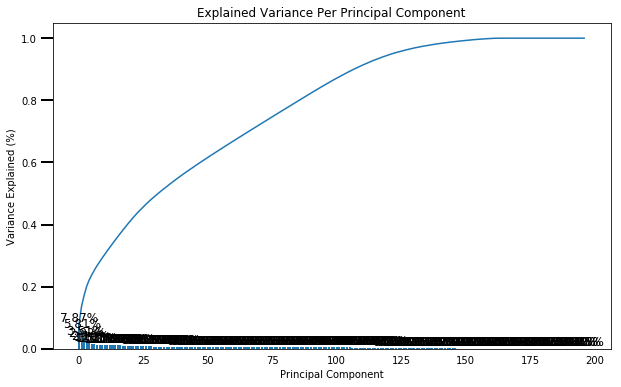

In [45]:
# Investigate the variance accounted for by each principal component.
print(pca.explained_variance_ratio_[0:10])
cumvar = np.cumsum(pca.explained_variance_ratio_)
scree_plot(pca)
for i, v in np.ndenumerate(cumvar):
    print(f'For componet {i}, comulative variance is: {v}')

In [46]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 97)
azdias_pca = pca.fit_transform(azdias_scaled)

[0.07879995 0.05815818 0.03516294 0.02925169 0.02100356 0.01615542
 0.01514805 0.01370245 0.01253365 0.01222647]


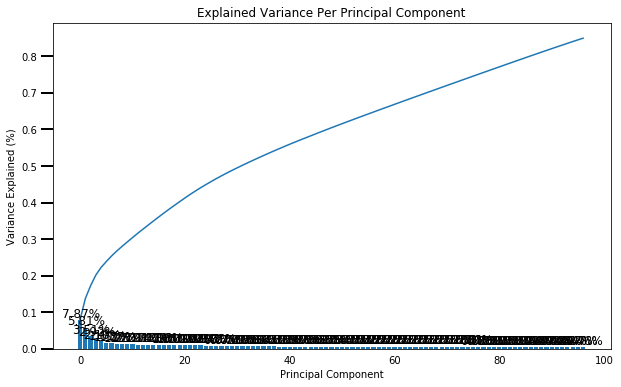

In [47]:
print(pca.explained_variance_ratio_[0:10])
cumvar = (np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_))
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

The data has 197 features. Doing a full PCA (all components), it's concluded that the least 50 components retain only 1% of the variance. In other words, ignoring those 50 components will likely have no effect on the subsequent analysis.

However, I decided to use 97 components. This would retain 85% of the variance. This is an adequate figure for the subsequent anlaysis, while keeping the number of components reasonable (not too many components)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [48]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pd.options.display.max_rows = 8

weigths = pd.DataFrame(pca.components_, columns=azdias_scaled.columns)

# 1st component
weigths.iloc[0].sort_values()

MOBI_REGIO           -0.197856
FINANZ_MINIMALIST    -0.193751
KBA05_ANTG1          -0.187114
KBA05_GBZ            -0.179583
                        ...   
PLZ8_ANTG3            0.176708
wealth                0.182276
HH_EINKOMMEN_SCORE    0.186117
LP_STATUS_GROB_1.0    0.194437
Name: 0, Length: 197, dtype: float64

In [49]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#2nd component
weigths.iloc[1].sort_values()


FINANZ_SPARER           -0.219975
FINANZ_UNAUFFAELLIGER   -0.210396
SEMIO_REL               -0.210234
SEMIO_TRADV             -0.203263
                           ...   
SEMIO_ERL                0.178029
ZABEOTYP_3               0.198890
FINANZ_VORSORGER         0.212073
ALTERSKATEGORIE_GROB     0.225840
Name: 1, Length: 197, dtype: float64

In [50]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#3rd component
weigths.iloc[2].sort_values()


ANREDE_KZ    -0.329562
SEMIO_KAEM   -0.297264
SEMIO_DOM    -0.263808
SEMIO_KRIT   -0.253201
                ...   
SEMIO_KULT    0.238554
SEMIO_SOZ     0.250283
SEMIO_FAM     0.251994
SEMIO_VERT    0.307872
Name: 2, Length: 197, dtype: float64

### Discussion 2.3: Interpret Principal Components

In examining the components weights, we can know which features are most important to each component. The most important features are those with the largest absolute weight. 

#### PC1
The most important features are  
**MOBI_REGIO**; movements pattern  
**FINANZ_MINIMALIST**; financial topology for minimalist  
**LP_STATUS_GROB_01**; social status, low income earners  
**HH_EINKOMMEN_SCORE**; estimated household net income  

#### PC2
**FINANZ_SPARER**; financial topology for sparer  
**FINANZ_UNAUFFAELLIGER**; financial topology for unauffaelliger  
**FINANZ_VORSORGER**; financial topoligy for vorsorger   
**ALTERSKATEGORIE_GROB**; Estimated age based on given name analysis  

#### PC3
**ANREDE_KZ**; gender  
**SEMIO_KAEM**; personality typology, for kaem  
**SEMIO_FAM**; personality typology, for fam  
**SEMIO_VERT**; personality typology, for vert  



#### Summary
It's noticed that PC1 is mosly formed by the features that related to financial status, PC2 is most affected by features also related to financial status, whereas PC3 is moslt affected by features related to personality or gender.




## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [51]:
# Over a number of different cluster counts...
k_list = list(range(2,13)) + list(range(13,21,2) + list(range(21,31,3)))
#k_list = [2, 3, 4]
score_list = []
inertia_list = []
for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(azdias_pca)
    inertia = kmeans.inertia_
    score = kmeans.score(azdias_pca)
    print(f'For K={k}, Score: {score:.2f} & Inertia: {inertia:.2f}')
    score_list.append(score)
    inertia_list.append(inertia)
    

For K=2, Score: -114049359.90 & Inertia: 114049359.90
For K=3, Score: -109545870.17 & Inertia: 109545870.17
For K=4, Score: -106556153.53 & Inertia: 106556153.53


Text(0.5,1,'Score vs. Number of clusters')

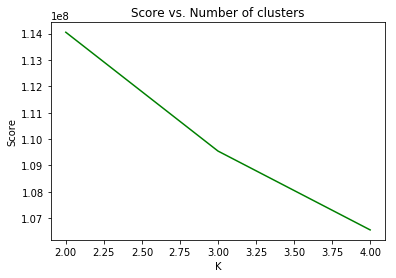

In [52]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(k_list, inertia_list, color='g')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Score vs. Number of clusters')

***Though there's no clear elbow in the above plot, I prefer to have K=8. This is a middle point where the distance score is almost stabilised, yet it's a suitable size for the subsequemt analysis***

In [53]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k_selected = 8
kmeans = KMeans(n_clusters=k_selected, random_state=0)
kmeans.fit(azdias_pca)
pop_clusters = kmeans.labels_
#azdias_imputed['cluster'] = clusters


### Discussion 3.1: Apply Clustering to General Population

Though there's no clear elbow in the above plot, I prefer to have K=8. This is a middle point where the distance score is almost stabilised, yet it's a suitable size for analysis of each customer clsuster.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [54]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
print(customers.shape)
customers.head()

(191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [55]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# clean the data (missing values & encoding)
customers_wrangled = clean_data(customers)
print(customers_wrangled.shape)
customers_wrangled.head()

(130927, 196)


,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,KONSUMNAEHE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,...,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,decade_40s,decade_50s,decade_60s,decade_70s,decade_80s,decade_90s,movement_Avantgarde,movement_Mainstream
0,1,1,0,1,4,5,1,5,1,2,2,1,5,6,5,2,6,6,7,3,4,1,3,1,1,2,1,1,6,9,5,2,2,0,0,4,3,2,4,4,1,4,3,1,3,3,1,0,5,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,1,0,2,4,5,1,5,1,4,4,2,5,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,6,9,1,2,2,0,0,3,7,4,1,3,3,3,1,7,2,3,3,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1,0,0,2,3,3,1,4,4,5,2,3,5,4,5,4,6,5,6,4,5,5,3,5,2,5,4,6,2,9,1,0,3,2,0,3,3,4,4,3,4,3,5,7,2,4,2,1,3,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1,1,0,2,3,5,1,5,1,2,3,3,3,6,4,4,1,7,6,4,6,2,5,5,3,3,4,1,6,9,2,2,2,1,0,3,7,5,8,4,2,3,3,3,2,3,2,1,5,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,1,1,0,1,4,5,1,5,1,1,2,2,5,4,2,5,1,6,5,3,4,3,3,1,2,2,4,2,6,9,4,4,1,0,0,4,6,2,5,4,2,4,4,3,3,2,1,0,5,5,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [56]:
list(customers_wrangled)

['ANREDE_KZ',
 'GREEN_AVANTGARDE',
 'SOHO_KZ',
 'VERS_TYP',
 'ALTERSKATEGORIE_GROB',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'KONSUMNAEHE',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'MIN_GEBAEUDEJAHR',
 'KBA13_ANZAHL_PKW',
 'wealth',
 'life_stage',
 'CJ

In [57]:
# I added this column manually to the customer dataframe.
# It's missing because it is a missing category in the customer data. However
# it did exist in the demographic data.
# That's a drawback of using Pandas dummies instead of sklearn OneHotEncoder
# OneHotEncoder would allow me to transform new data using the previoulsly learnt fit
customers_wrangled['GEBAEUDETYP_5.0'] = 0

In [58]:
# scale the data
scaled = scaler.transform(customers_wrangled)
customers_scaled = pd.DataFrame(scaled, columns=customers_wrangled.columns)

# pca
customers_pca = pca.transform(customers_scaled)

In [59]:
# kmeans
customers_clusters = kmeans.predict(customers_pca)
customers_clusters.shape

(130927,)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [60]:
pop_values, pop_counts = np.unique(pop_clusters, return_counts=True)
cust_values, cust_counts = np.unique(customers_clusters, return_counts=True)

In [61]:
cluster_counts=pd.DataFrame(zip(pop_counts, cust_counts), index=pop_values)
cluster_counts = cluster_counts.rename(columns={0: 'PopCounts', 1:'CustCounts'})
cluster_counts['PopProp'] = cluster_counts['PopCounts'] / pop_counts.sum()
cluster_counts['CustProp'] = cluster_counts['CustCounts'] / cust_counts.sum()
cluster_counts.drop(columns=['PopCounts', 'CustCounts'], inplace = True)
cluster_counts

,PopProp,CustProp
0,0.152346,0.465084
1,0.097463,0.073071
2,0.151790,0.210866
3,0.123785,0.008661
4,0.121960,0.024815
5,0.115887,0.089500
6,0.140865,0.120602
7,0.095903,0.007401


In [62]:
# reshape the proportions dataframe to make plotting easier
cluster_props = cluster_counts.reset_index().melt(id_vars='index', value_vars=['PopProp', 'CustProp'])\
.rename(columns={'index':'Cluster', 'variable': 'DataSet', 'value':'Proportion'})
cluster_props 

,Cluster,DataSet,Proportion
0,0,PopProp,0.152346
1,1,PopProp,0.097463
2,2,PopProp,0.151790
3,3,PopProp,0.123785
...,...,...,...
12,4,CustProp,0.024815
13,5,CustProp,0.089500
14,6,CustProp,0.120602
15,7,CustProp,0.007401


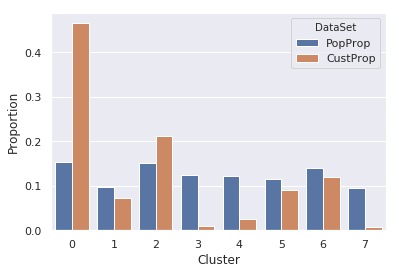

In [63]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
sns.set(style="darkgrid")
ax = sns.barplot(x='Cluster', y='Proportion', hue='DataSet', data = cluster_props)


In [64]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# clusters 1 & 3 -- choose 1 for analysis
clust1 = pd.DataFrame(kmeans.cluster_centers_[1])
clust1.reset_index().rename(columns={'index':'PC', 0:'Distance'}).sort_values(by = 'Distance')

,PC,Distance
2,2,-1.680443
0,0,-1.451986
7,7,-1.195428
4,4,-1.175369
...,...,...
20,20,0.470406
6,6,0.636935
5,5,1.405005
1,1,2.066454


The PCs that have the largest distance to centroid have the largest impact on the centroid. For cluster 1, those are PC1 & PC4  
It's a negative sign, so smaller values are more relevant  
**For PC1**  
**MOBI_REGIO**; movements pattern --> very high movement  
**FINANZ_MINIMALIST**; financial topology for minimalist --> Very high financial topology  
**LP_STATUS_GROB_01**; social status, low income earners  --> Not labelled as low income earner  
**HH_EINKOMMEN_SCORE**; estimated household net income --> People with high income 

***The above is a dsecription of the customers that are relatively popular with the mail order***


In [65]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# clusters 0, 2, 5 & 7 -- choose 5 for analysis
clust5 = pd.DataFrame(kmeans.cluster_centers_[5])
clust5.reset_index().rename(columns={'index':'PC', 0:'Distance'}).sort_values(by = 'Distance')

,PC,Distance
2,2,-1.665854
14,14,-0.207473
21,21,-0.202544
17,17,-0.152114
...,...,...
4,4,0.511062
3,3,0.753637
0,0,2.604311
1,1,4.467870


PC3 is the most contributing to cluster5 with a +ve sign, so larger value denote more influence.  
***People in this group are less likely to be customers of the mail order company***

#### PC3
**ANREDE_KZ**; gender  ==> females  
**SEMIO_KAEM**; personality typology, for kaem  ==> lowest affinity  
**SEMIO_FAM**; personality typology, for fam  ==> lowest affinity  
**SEMIO_VERT**; personality typology, for vert  ==> lowest affinity  

### Discussion 3.3: Compare Customer Data to Demographics Data

Please refer to the cells above for a detailed analysis

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.